# Importing Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pipelining and Preprocessing

Note: Train with other type of data also

In [ ]:
from tensorflow.keras.preprocessing import image

import numpy as np

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm


Using Dataset_2 as the main training data for results

In [ ]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Final_Dataset_Augmented_and_mirror_all_new/'

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
img_data_list = []
image_path_list = []

In [ ]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

  2%|▏         | 23/1000 [00:00<00:04, 226.34it/s]

Loading the images of dataset - Covid-19



  2%|▎         | 25/1000 [00:00<00:03, 245.90it/s]

Loading the images of dataset - Normal



  3%|▎         | 29/1000 [00:00<00:03, 284.25it/s]

Loading the images of dataset - Pneumonia



 78%|███████▊  | 783/1000 [00:02<00:00, 288.02it/s]


In [ ]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(2400, 224, 224, 3)


In [ ]:
len(image_path_list)

2400

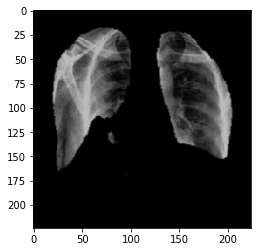

In [ ]:
plt.imshow(img_data[500])

In [ ]:
img_data.dtype

dtype('int32')

# Neural Network Training

Note: use other networks also

## Data Preprocessing 

In [ ]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [ ]:
labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
labels.shape

(2400,)

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

#X_model, X_test,Y_model, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [ ]:
X_test_NN.shape

(480, 224, 224, 3)

In [ ]:
X_train_NN.shape

(1920, 224, 224, 3)

In [ ]:
y_train_NN.shape

(1920, 3)

## Training

90

In [ ]:
import tensorflow as tf
# shape 224, 224, 3

In [ ]:
VGG_19 = tf.keras.applications.VGG19(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

In [ ]:
VGG_19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model
last_layer = VGG_19.get_layer('flatten').output
x = Dense(4096, activation='relu', name='fc1')(last_layer)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
out = Dense(num_classes, activation = 'softmax', name = 'output')(x)
custom_model = Model(VGG_19.input, out)

In [ ]:
for layer in custom_model.layers[:-4]:
    layer.trainable = False

In [ ]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [ ]:
custom_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
custom_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
X_train_pp = preprocess_input(X_train_NN)
X_test_pp = preprocess_input(X_test_NN)
#X_test = preprocess_input(X_test)

In [ ]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('VGG_19.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [ ]:
custom_model.fit(X_train_pp, y_train_NN, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_pp, y_test_NN), callbacks = callbacks)

Epoch 1/100
60/60 [==============================] - 19s 312ms/step - loss: 16.2791 - accuracy: 0.7464 - val_loss: 1.0827 - val_accuracy: 0.8771
Epoch 2/100
60/60 [==============================] - 33s 542ms/step - loss: 0.4706 - accuracy: 0.9333 - val_loss: 0.4263 - val_accuracy: 0.9146
Epoch 3/100
60/60 [==============================] - 12s 199ms/step - loss: 0.1482 - accuracy: 0.9656 - val_loss: 0.4578 - val_accuracy: 0.9375
Epoch 4/100
60/60 [==============================] - 22s 373ms/step - loss: 0.0663 - accuracy: 0.9828 - val_loss: 0.2485 - val_accuracy: 0.9625
Epoch 5/100
60/60 [==============================] - 12s 197ms/step - loss: 0.1409 - accuracy: 0.9750 - val_loss: 0.3708 - val_accuracy: 0.9458
Epoch 6/100
60/60 [==============================] - 22s 364ms/step - loss: 0.1090 - accuracy: 0.9818 - val_loss: 0.1757 - val_accuracy: 0.9750
Epoch 7/100
60/60 [==============================] - 34s 565ms/step - loss: 0.0280 - accuracy: 0.9927 - val_loss: 0.1712 - val_accuracy

In [ ]:
classifier = tf.keras.models.load_model("VGG_19.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = classifier.predict(X_test_pp)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_NN,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[161   0   0]
 [  0 162   5]
 [  1   4 147]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       161
           1       0.98      0.97      0.97       167
           2       0.97      0.97      0.97       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



###Testing the model with ML techniques

In [ ]:
classifier = tf.keras.models.load_model("VGG_19.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [ ]:
Model_new.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
x_new,y_new = shuffle(img_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.1, random_state = 2)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
X_train_1 = preprocess_input(X_train_1)
X_test_1 = preprocess_input(X_test_1)

In [ ]:
y_train_1.shape

(1350,)

In [ ]:
train_new = Model_new.predict(X_train_1)
test_new = Model_new.predict(X_test_1)
print(test_new)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
test_new.shape

(150, 256)

#### svm

94 and 90

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', max_iter = 50000)

svm.fit(train_new,y_train_1)
print('fitting done !!!')
svm.score(train_new,y_train_1)

fitting done !!!


0.9911111111111112

fc3

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 0 49  1]
 [ 0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      0.98      0.99        50
           2       0.98      1.00      0.99        47

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



#### xg_boost

92 and 91

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

xb.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 0 49  1]
 [ 0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      0.98      0.99        50
           2       0.98      1.00      0.99        47

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



#### random forest

93 and 90

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=2000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

rf.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 0 49  1]
 [ 0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      0.98      0.99        50
           2       0.98      1.00      0.99        47

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



# Descriptors Extraction and Training

## Preprocessing the Data

In [ ]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 129kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 103kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Using: SIFT

In [ ]:
import cv2

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [00:50<00:00, 47.52it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

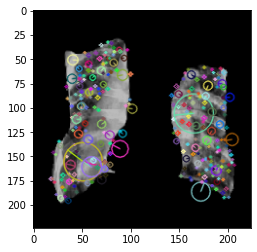

In [ ]:
plt.imshow(image)
plt.show()

Using BRISK

In [ ]:
import cv2

In [ ]:
brisk = cv2.BRISK_create(50)
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [00:07<00:00, 307.62it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

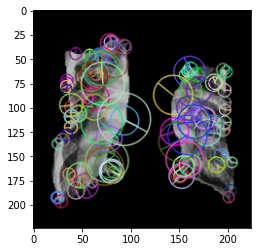

In [ ]:
plt.imshow(image)
plt.show()

stacking all the descriptors vertically in a numpy array

In [ ]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 2400/2400 [00:02<00:00, 918.01it/s]


In [ ]:
descriptors_float = descriptors.astype(float)

Clustring using k means

Note: use others methods also

In [ ]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

calculating the histogram of the features and representing them as vectors.

vq(vector quantization) Assigns codes from a code book to observations.

In [ ]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 2400/2400 [00:01<00:00, 1326.39it/s]


performing Tf-Idf vectorization

In [ ]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

Scaling the words

Standardize features by removing the mean and scaling to unit variance

In a way normalizarion

In [ ]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [ ]:
im_features.shape

(2400, 128)

In [ ]:
im_features.dtype

dtype('float32')

## Train and Test spliting 

In [ ]:
num_classes = 3
num_of_samples = im_features.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
x,y = shuffle(im_features,labels, random_state=2)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x, y, test_size = 0.15, random_state = 2)

In [ ]:
X_train_d.shape

(2040, 128)

In [ ]:
y_train_d.shape

(2040,)

## Training with SIFT

### Training on SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(X_train_d,y_train_d)

0.9519607843137254

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[103   2  13]
 [  0 121  16]
 [ 13   8  84]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       118
           1       0.92      0.88      0.90       137
           2       0.74      0.80      0.77       105

    accuracy                           0.86       360
   macro avg       0.85      0.85      0.85       360
weighted avg       0.86      0.86      0.86       360



### Training on XG_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(X_train_d,y_train_d)

0.9416666666666667

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[104   1  13]
 [  0 116  21]
 [ 15   8  82]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       118
           1       0.93      0.85      0.89       137
           2       0.71      0.78      0.74       105

    accuracy                           0.84       360
   macro avg       0.84      0.84      0.84       360
weighted avg       0.85      0.84      0.84       360



### Training on Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(X_train_d,y_train_d)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 92   1  25]
 [  0 119  18]
 [ 12   9  84]]
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       118
           1       0.92      0.87      0.89       137
           2       0.66      0.80      0.72       105

    accuracy                           0.82       360
   macro avg       0.82      0.82      0.82       360
weighted avg       0.83      0.82      0.82       360



## Training with BRISK

### Training on SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(X_train_d,y_train_d)

0.875

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 85  11  22]
 [  2 108  27]
 [ 11  11  83]]
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       118
           1       0.83      0.79      0.81       137
           2       0.63      0.79      0.70       105

    accuracy                           0.77       360
   macro avg       0.78      0.77      0.77       360
weighted avg       0.78      0.77      0.77       360



### Training on XG_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(X_train_d,y_train_d)

0.8544117647058823

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[79 12 27]
 [ 2 99 36]
 [12 16 77]]
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       118
           1       0.78      0.72      0.75       137
           2       0.55      0.73      0.63       105

    accuracy                           0.71       360
   macro avg       0.73      0.71      0.71       360
weighted avg       0.74      0.71      0.71       360



### Training on Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(X_train_d,y_train_d)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 81   9  28]
 [  2 106  29]
 [ 11  20  74]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.76       118
           1       0.79      0.77      0.78       137
           2       0.56      0.70      0.63       105

    accuracy                           0.73       360
   macro avg       0.74      0.72      0.72       360
weighted avg       0.75      0.72      0.73       360



# Combining all the Processes

In [ ]:
import tensorflow as tf

In [ ]:
Model_s = tf.keras.models.load_model("VGG_19.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [ ]:
Model_C.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
img_data = preprocess_input(img_data)

In [ ]:
Pred_fc3 = Model_C.predict(img_data)

In [ ]:
Pred_fc3.shape

(2400, 256)

In [ ]:
Pred_fc3.dtype

dtype('float32')

In [ ]:
type(Pred_fc3)

numpy.ndarray

also using the extracted features using opencv

In [ ]:
im_features.shape

(2400, 128)

In [ ]:
im_features.dtype

dtype('float32')

In [ ]:
type(im_features)

numpy.ndarray

combining the data from pred_fc3 and im_features

In [ ]:
total_features = 384

In [ ]:
total_dataset = 2400

In [ ]:
feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

In [ ]:
feature_data.shape

(2400, 384)

In [ ]:
for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 2400/2400 [00:00<00:00, 187619.14it/s]


In [ ]:
feature_data

array([[ 5.3503227e-01, -7.0806712e-01,  9.3912798e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.8152905e+00,  2.9515097e-04,  9.0518363e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.3503227e-01,  2.9515097e-04, -7.5809127e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-5.3503227e-01,  2.9515097e-04, -7.5809127e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.3503227e-01, -7.0806712e-01,  9.3912798e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.3503227e-01, -7.0806712e-01,  9.0518363e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Train Test split

change accordance to the type of training

In [ ]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

Use Different Train Test Splitting --> 0.05, 0.1, 0.2, 0.3

In [ ]:
# use the following line training the Deep learning Model
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(feature_data,Y, random_state=2)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [ ]:
X_train_c.shape

(1920, 384)

In [ ]:
y_train_c.shape

(1920, 3)

## Training DL model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model_combined = Sequential()
model_combined.add(Dense(1024, input_dim=384, activation='relu', name='dense_1'))
model_combined.add(Dense(800, activation='relu', name='dense_2'))
model_combined.add(Dense(512, activation='relu', name='dense_3'))
model_combined.add(Dense(300, activation='relu', name='dense_4'))
model_combined.add(Dense(256, activation='relu', name='dense_5'))
model_combined.add(Dense(128, activation='relu', name='dense_6'))
model_combined.add(Dense(3, activation='softmax', name = 'output_layer'))

In [ ]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [ ]:
model_combined.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

make wider, make deeper, make wider and deeper, and also use other methods

In [ ]:
model_combined.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 3)                 3

In [ ]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('VGG_19_combined_BRISK.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [ ]:
model_combined.fit(X_train_c, y_train_c, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_c, y_test_c), callbacks = callbacks)

Epoch 1/100
60/60 [==============================] - 0s 7ms/step - loss: 0.4216 - accuracy: 0.9323 - val_loss: 0.1912 - val_accuracy: 0.9729
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 5.2036e-06 - accuracy: 1.0000 - val_loss: 0.2069 - val_accuracy: 0.9750
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 1.1952e-06 - accuracy: 1.0000 - val_loss: 0.2148 - val_accuracy: 0.9750
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 5.4945e-07 - accuracy: 1.0000 - val_loss: 0.2269 - val_accuracy: 0.9750
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 3.5097e-07 - accuracy: 1.0000 - val_loss: 0.2380 - val_accuracy: 0.9750
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 2.0923e-07 - accuracy: 1.0000 - val_loss: 0.2452 - val_accuracy: 0.9771
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 1.8607e-07 - accuracy: 1.0000 - val_loss: 0.2519 - val_accura

In [ ]:
Model_n = tf.keras.models.load_model("VGG_19_combined_BRISK.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_c)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_c,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[161   0   0]
 [  0 161   6]
 [  2   5 145]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       0.97      0.96      0.97       167
           2       0.96      0.95      0.96       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



SIFT ACCURACY was 98%

## Using ML methods

In [ ]:
Model_n = tf.keras.models.load_model("VGG_19_combined_BRISK.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [ ]:
Model_csn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   [(None, 384)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [ ]:
x_new,y_new = shuffle(feature_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.2, random_state = 2)

In [ ]:
train_new = Model_csn.predict(X_train_1)
test_new = Model_csn.predict(X_test_1)
print(test_new)

[[9.2405602e-02 1.0640331e+01 9.7631893e+00 ... 4.1418067e-01
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 5.3509212e+00 5.4852033e+00 ... 8.3982283e-01
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 9.0746861e+00 7.4326973e+00 ... 9.8407604e-03
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 2.3982222e+01 1.9103109e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.6887571e+01 1.3705956e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.2604971e+01 1.0074576e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


###Results With SIFT - Scale Invarient Feature Transform

#### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(train_new, y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 161   6]
 [  1   4 147]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       161
           1       0.98      0.96      0.97       167
           2       0.96      0.97      0.96       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



#### xg_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[157   0   4]
 [  0 162   5]
 [  1   5 146]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       161
           1       0.97      0.97      0.97       167
           2       0.94      0.96      0.95       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   0   1]
 [  0 161   6]
 [  1   4 147]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       0.98      0.96      0.97       167
           2       0.95      0.97      0.96       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.98      0.97      0.98       480



###Results With BRISK - Binary Robust Invarient Scalable Keypoints

#### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(train_new, y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 161   6]
 [  2   4 146]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       0.98      0.96      0.97       167
           2       0.96      0.96      0.96       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



#### xg_boost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
xb.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 160   7]
 [  1   3 148]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       161
           1       0.98      0.96      0.97       167
           2       0.95      0.97      0.96       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



#### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [ ]:
rf.score(train_new,y_train_1)

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 162   5]
 [  2   4 146]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       0.98      0.97      0.97       167
           2       0.97      0.96      0.96       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



# Testing the models

## Dataset Preprocessing

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Testing_Dataset/'

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
img_data_list = []
image_path_list = []

In [ ]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

 40%|███▉      | 36/91 [00:00<00:00, 350.30it/s]

Loading the images of dataset - Covid-19



 41%|████      | 37/91 [00:00<00:00, 365.51it/s]

Loading the images of dataset - Normal



 39%|███▉      | 38/97 [00:00<00:00, 369.97it/s]

Loading the images of dataset - Pneumonia



100%|██████████| 97/97 [00:00<00:00, 352.18it/s]


In [ ]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(279, 224, 224, 3)


In [ ]:
len(image_path_list)

279

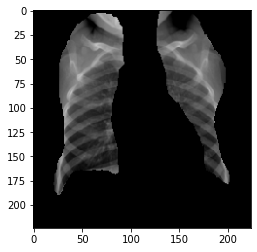

In [ ]:
plt.imshow(img_data[100])

In [ ]:
img_data.dtype

dtype('int32')

In [ ]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [ ]:
labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
labels.shape

(279,)

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

X_test,Y_test = shuffle(img_data,Y, random_state=2)

## Simple Model

In [ ]:
Model_n = tf.keras.models.load_model("VGG_19.h5")

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
X_test = preprocess_input(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[89  0  2]
 [ 0 85  6]
 [ 1  6 90]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        91
           1       0.93      0.93      0.93        91
           2       0.92      0.93      0.92        97

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279



ML Techniques

In [ ]:
classifier = tf.keras.models.load_model("VGG_19.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [ ]:
x_test_new,y_test_new = shuffle(img_data,labels, random_state=2)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
x_test_new = preprocess_input(x_test_new)

In [ ]:
test_new_x = Model_new.predict(x_test_new)

svm

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 0 86  5]
 [ 2  9 86]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        91
           1       0.91      0.95      0.92        91
           2       0.93      0.89      0.91        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



xg_boost

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[91  0  0]
 [ 0 89  2]
 [ 4 13 80]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        91
           1       0.87      0.98      0.92        91
           2       0.98      0.82      0.89        97

    accuracy                           0.93       279
   macro avg       0.94      0.93      0.93       279
weighted avg       0.94      0.93      0.93       279



random_forest

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[91  0  0]
 [ 0 87  4]
 [ 3 12 82]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        91
           1       0.88      0.96      0.92        91
           2       0.95      0.85      0.90        97

    accuracy                           0.93       279
   macro avg       0.93      0.93      0.93       279
weighted avg       0.93      0.93      0.93       279



## Feature Extraction

### SIFT

In [ ]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

In [ ]:
import cv2

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:05<00:00, 46.90it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

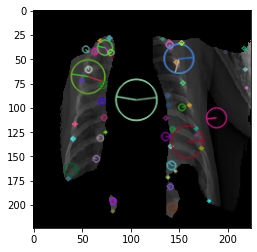

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 402.63it/s]


In [ ]:
descriptors_float = descriptors.astype(float)

In [ ]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [ ]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 750.87it/s]


In [ ]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [ ]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [ ]:
im_features.shape

(279, 128)

In [ ]:
im_features.dtype

dtype('float32')

In [ ]:
Model_s = tf.keras.models.load_model("VGG_19.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
img_data = preprocess_input(img_data)

In [ ]:
Pred_fc3 = Model_C.predict(img_data)

In [ ]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 95061.80it/s]


In [ ]:
feature_data.shape

(279, 384)

In [ ]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [ ]:
Model_n = tf.keras.models.load_model("VGG_19_combined_SIFT.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[88  0  3]
 [ 0 84  7]
 [ 1  6 90]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        91
           1       0.93      0.92      0.93        91
           2       0.90      0.93      0.91        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



#### ML Techniques

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [ ]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [ ]:
new_test_x = Model_csn.predict(x_new_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [ ]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[88  0  3]
 [ 0 84  7]
 [ 1  6 90]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        91
           1       0.93      0.92      0.93        91
           2       0.90      0.93      0.91        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



xg_boost

In [ ]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[84  0  7]
 [ 0 83  8]
 [ 1  6 90]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        91
           1       0.93      0.91      0.92        91
           2       0.86      0.93      0.89        97

    accuracy                           0.92       279
   macro avg       0.93      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279



random forest

In [ ]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[88  0  3]
 [ 0 84  7]
 [ 1  6 90]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        91
           1       0.93      0.92      0.93        91
           2       0.90      0.93      0.91        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



### BRISK

In [ ]:
import cv2

In [ ]:
brisk = cv2.BRISK_create(50)
des_list = []

In [ ]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:00<00:00, 280.58it/s]


In [ ]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

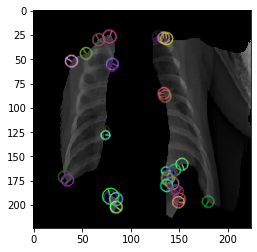

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 5585.57it/s]


In [ ]:
descriptors_float = descriptors.astype(float)

In [ ]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [ ]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 1100.75it/s]


In [ ]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [ ]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [ ]:
im_features.shape

(279, 128)

In [ ]:
im_features.dtype

dtype('float32')

In [ ]:
Model_s = tf.keras.models.load_model("VGG_19.h5")

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
img_data = preprocess_input(img_data)

In [ ]:
Pred_fc3 = Model_C.predict(img_data)

In [ ]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 71193.70it/s]


In [ ]:
feature_data.shape

(279, 384)

In [ ]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [ ]:
Model_n = tf.keras.models.load_model("VGG_19_combined_BRISK.h5")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[90  0  1]
 [ 0 85  6]
 [ 1  7 89]]


In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        91
           1       0.92      0.93      0.93        91
           2       0.93      0.92      0.92        97

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279



#### ML Techniques

In [ ]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [ ]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [ ]:
new_test_x = Model_csn.predict(x_new_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [ ]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 0 85  6]
 [ 1  7 89]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        91
           1       0.92      0.93      0.93        91
           2       0.93      0.92      0.92        97

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279



xg_boost

In [ ]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  0  2]
 [ 0 83  8]
 [ 1  5 91]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        91
           1       0.94      0.91      0.93        91
           2       0.90      0.94      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



random forest

In [ ]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 0 84  7]
 [ 1  5 91]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        91
           1       0.94      0.92      0.93        91
           2       0.92      0.94      0.93        97

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279

